In [1]:
import sys

import blosc
import numpy as np
import matplotlib.pyplot as plt
from pandas import ewma
from tqdm import tqdm_notebook as tqn
from IPython.display import clear_output
%matplotlib inline
sys.path.append('..')
from network import FourHeadedInception
from batch_generator import TwoMnistBatch
from dataset import Dataset, B, V, Pipeline
from dataset.opensets import MNIST

In [2]:
dset = MNIST(batch_class=TwoMnistBatch)

ExtractingExtractingExtractingExtracting   /tmp/t10k-labels-idx1-ubyte.gz /tmp/train-labels-idx1-ubyte.gz/tmp/t10k-images-idx3-ubyte.gz
/tmp/train-images-idx3-ubyte.gz




In [3]:
ppl = (Pipeline()
       .resize(shape=(128, 128))
       .normalize_images()
       .concat_and_colorize_images())

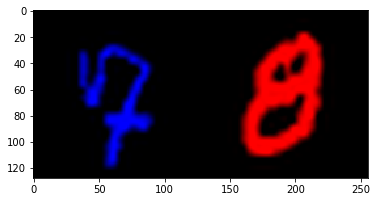

In [4]:
a = (ppl<<dset.train).next_batch(2)
plt.imshow(a.images[0])

In [5]:
inputs_config = {'images': {'shape':(128, 256, 3)},
                 'labels':{'classes':(10), 'transform': 'ohe'},
                 'col': {'classes':(2), 'transform': 'ohe', 'name':'color'},
                 'first': {'classes':(10), 'transform': 'ohe', 'name':'first_number'},
                 'second': {'classes':(10), 'transform': 'ohe', 'name':'second_number'}}

config = {'inputs':inputs_config,
          'optimizer': 'Adam',
          'loss': None,
          'input_block/inputs': 'images'}

four_headed_dict = {'images': B('images'),
                    'labels': B('labels'),
                    'col': B('color'),
                    'first': B('first_number'),
                    'second': B('second_number')}

In [9]:
four_headed_ppl = ((ppl<<dset.train)
                    .init_variable('loss', init_on_each_run=list)
                    .init_model('dynamic',
                                FourHeadedInception,
                                'fourinception',
                                config=config)
                   .train_model('fourinception',
                                fetches='loss',
                                feed_dict=four_headed_dict,
                               save_to=V('loss'), mode='a'))

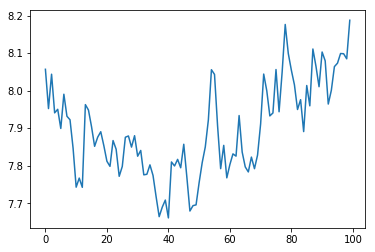

In [10]:
for i in tqn(range(2000)):
    four_headed_ppl.next_batch(23, n_epochs=None, shuffle=True)
    if i%10==0:
        clear_output(True)
        plt.plot(ewma(np.array(four_headed_ppl.get_variable('loss')[-100:]),span=10,adjust=False))
        plt.show()

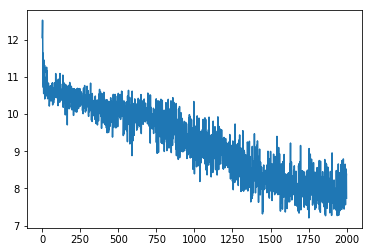

In [11]:
plt.plot(four_headed_ppl.get_variable('loss'))

In [12]:
four_headed_test = ((ppl<<dset.test)
                    .init_variable('first_color', init_on_each_run=list)
                    .init_variable('second_color', init_on_each_run=list)
                    .init_variable('first_num', init_on_each_run=list)
                    .init_variable('second_num', init_on_each_run=list)
                    .import_model('fourinception', four_headed_ppl)
                    .predict_model('fourinception', 
                                   fetches=['FourHeadedInception/first_color:0', 
                                            'FourHeadedInception/second_color:0',
                                            'FourHeadedInception/first_number:0',
                                            'FourHeadedInception/second_number:0'],
                         feed_dict=four_headed_dict,
                         save_to=[V('first_color'),
                                  V('second_color'), 
                                  V('first_num'), 
                                  V('second_num')], mode='a'))

0 1 1 9


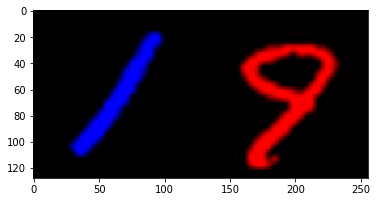

In [16]:
batch = four_headed_test.next_batch(10)
plt.imshow(batch.images[-1])
first_color = four_headed_test.get_variable('first_color')
second_color = four_headed_test.get_variable('second_color')
first_num = four_headed_test.get_variable('first_num')
second_num = four_headed_test.get_variable('second_num')
print(np.argmax(first_color[-1][-1]), np.argmax(second_color[-1][-1]), \
      np.argmax(first_num[-1][-1]), np.argmax(second_num[-1][-1]))